In [5]:
pip install --upgrade xgboost


Selected Features: ['RBC', 'Hb', 'MCV', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Tuning Logistic Regression...
Tuning Random Forest...
Tuning SVM...
Tuning LightGBM...
Tuning Decision Tree...
Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params XGBoost: {'subsample': 0.6, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best ROC AUC XGBoost tuning: 0.8056

Cross-Validation Accuracy Scores (Ensemble): [0.7421875 0.6953125 0.7890625 0.765625  0.7578125]
Mean CV Accuracy (Ensemble): 75.00%
Standard Deviation: 3.12%
Best Threshold: 0.46, Best F1 Score: 0.7956

Final Ensemble Model Performance:
Accuracy: 76.88%
ROC AUC Score: 82.66%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        80
           1       0.71      0.90      0.80        80

    accuracy                           0.77       160
   macro avg       0.7

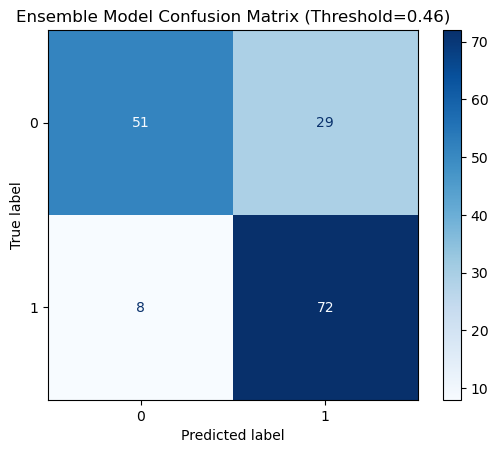

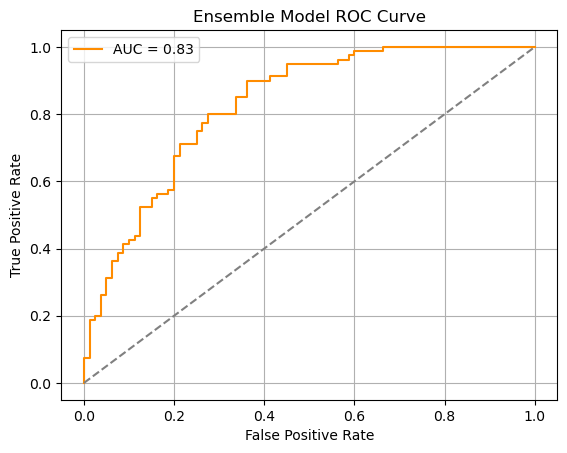

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = [base_features[i] for i in selector.get_support(indices=True)]
print(f"Selected Features: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter grids
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_rf = {'n_estimators': [100, 150], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
param_lgbm = {'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
param_dt = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
param_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize models and RandomizedSearchCV for tuning
lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)
lgbm_search = RandomizedSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_lgbm, cv=3, n_iter=5,
                                 scoring='roc_auc', random_state=42, n_jobs=-1)
dt_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
xgb_search = RandomizedSearchCV(xgb, param_xgb, n_iter=10, scoring='roc_auc', cv=3,
                                verbose=1, random_state=42, n_jobs=-1)

# Fit all tunings
print("Tuning Logistic Regression...")
lr_search.fit(X_train, y_train)

print("Tuning Random Forest...")
rf_search.fit(X_train, y_train)

print("Tuning SVM...")
svm_search.fit(X_train, y_train)

print("Tuning LightGBM...")
lgbm_search.fit(X_train, y_train)

print("Tuning Decision Tree...")
dt_search.fit(X_train, y_train)

print("Tuning XGBoost...")
xgb_search.fit(X_train, y_train)

print(f"Best params XGBoost: {xgb_search.best_params_}")
print(f"Best ROC AUC XGBoost tuning: {xgb_search.best_score_:.4f}")

# Best XGBoost estimator
xgb_model_tuned = xgb_search.best_estimator_

# Build ensemble with all tuned models
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('rf', rf_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
        ('xgb', xgb_model_tuned),
        ('lgbm', lgbm_search.best_estimator_),
        ('dt', dt_search.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Cross-validation accuracy on training set
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Ensemble): {cv_scores}")
print(f"Mean CV Accuracy (Ensemble): {cv_scores.mean()*100:.2f}%")
print(f"Standard Deviation: {cv_scores.std()*100:.2f}%")

# Predict probabilities on test set
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Find best threshold by maximizing F1 score
def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions using best threshold
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluate final model
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save predictions with additional info
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble_model_predictions_anemia_optimized.csv')
print("Predictions saved to 'ensemble_model_predictions_anemia_optimized.csv'")

# Confusion Matrix plot
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Threshold={best_threshold:.2f})")
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Selected Features: ['RBC', 'Hb', 'MCV', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Tuning Logistic Regression...
Tuning SVM...

Cross-Validation Accuracy Scores (Ensemble): [0.6875    0.7109375 0.7265625 0.75      0.78125  ]
Mean CV Accuracy (Ensemble): 73.12%
Standard Deviation: 3.22%
Best Threshold: 0.49, Best F1 Score: 0.8024

Final Ensemble Model Performance:
Accuracy: 79.38%
ROC AUC Score: 82.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        80
           1       0.77      0.84      0.80        80

    accuracy                           0.79       160
   macro avg       0.80      0.79      0.79       160
weighted avg       0.80      0.79      0.79       160

Predictions saved to 'ensemble2_model_predictions_anemia_optimized.csv'


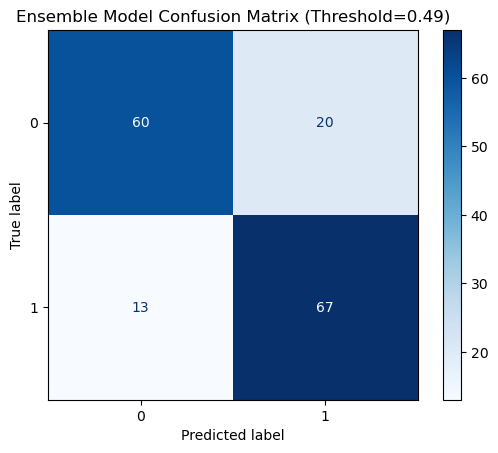

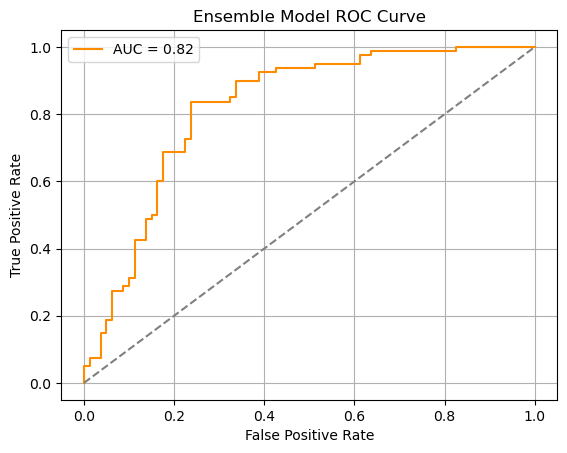

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = [base_features[i] for i in selector.get_support(indices=True)]
print(f"Selected Features: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter grids
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}

# Initialize models and RandomizedSearchCV for tuning
lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)

# Fit tunings
print("Tuning Logistic Regression...")
lr_search.fit(X_train, y_train)

print("Tuning SVM...")
svm_search.fit(X_train, y_train)

# Build ensemble with tuned Logistic Regression and SVM
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
    ],
    voting='soft',
    n_jobs=-1
)

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Cross-validation accuracy on training set
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Ensemble): {cv_scores}")
print(f"Mean CV Accuracy (Ensemble): {cv_scores.mean()*100:.2f}%")
print(f"Standard Deviation: {cv_scores.std()*100:.2f}%")

# Predict probabilities on test set
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Find best threshold by maximizing F1 score
def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions using best threshold
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluate final model
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save predictions with additional info
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble1_model_predictions_anemia_optimized.csv')
print("Predictions saved to 'ensemble2_model_predictions_anemia_optimized.csv'")

# Confusion Matrix plot
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Threshold={best_threshold:.2f})")
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
